In [1]:
from simulation import *
from power_typeIerror import *
from collections import OrderedDict
import numpy as np
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
pandas2ri.activate()
readRDS = robjects.r['readRDS']
from numpy import inf

In [2]:
def get_causal_pvalue_from_pkl(input_data):
    dat = load_data(input_data)
    causal_genes = set(dat["debug"]["causal genes"])
    sample_genes = get_gene_table(dat)
    fisher_table = test_contingency_table(sample_genes)
    overlap_genes = list(causal_genes.intersection(fisher_table["genes"]))
    indices = [fisher_table["genes"].index(x) for x in overlap_genes]
    log_overlap_pvalue = [-np.log10(fisher_table["p_value"][num]) for num in indices]
    pvalue_df = OrderedDict(sorted(zip(*[overlap_genes, log_overlap_pvalue]), key = lambda x: x[1], reverse=True))
    return overlap_genes, pvalue_df

In [ ]:
overlap_genes_from_pkl, pvalue_df_pkl = get_causal_pvalue_from_pkl(
    "data/del_sim_shape5_scale1_p0.01_N4000_M100_12.data.pkl")

In [6]:
def get_lfdr(rds_data, overlap_genes_from_pkl, inf_sub = 0):
    df = readRDS(rds_data)
    df = pandas2ri.ri2py(df)
    # print (df.names)
    # "20" is "pip", "18" is "summary"
    pip_rds = df[20]
    pip_genes = list(pip_rds.names[0])
    pip_list = np.array(np.matrix(pip_rds)).reshape(-1,).tolist()
    lfdr = [1-x for x in pip_list]
    gene_index = [pip_genes.index(gene) for gene in overlap_genes_from_pkl]
    log_lfdr_overlap = [-np.log10(lfdr[index]) for index in gene_index]
    # replace infinity with maximum of log10(pvalue) plus the median of it
    log_lfdr_overlap = [x if not np.isinf(x) else inf_sub for x in log_lfdr_overlap]
    lfdr_df = OrderedDict(sorted(zip(*[overlap_genes_from_pkl, log_lfdr_overlap]), 
                                 key = lambda x: x[1], reverse=True))
    return lfdr_df

In [11]:
comb = {"p1": [], "p2": [], "gene": []}
import matplotlib.pyplot as plt
for gene, pvalue in lfdr_df_rds.items():
    comb["p1"].append(pvalue_df_pkl[gene])
    comb["p2"].append(pvalue)
    comb["gene"].append(gene)
print (comb)

{'p2': [8.38766615213477, 1.1513495296140523, 0.99572276183519082, 0.22189829416145843, 0.10476823696014212, 0.096639218022880197, 0.087263486859466846, 0.083174929249326929, 0.074578919449324765, 0.06140308757177549, 0.044806983921961169, 0.042568389922506847, 0.035682808901918044, 0.033527245038569173, 0.032663213563200309, 0.032174110228294812, 0.028537985451091704, 0.023308731995297274, 0.022877119081008895, 0.021558689603370207, 0.021351390365639503, 0.020435359401592371, 0.019853136590562506, 0.019370459928301956, 0.019002863238303976, 0.018443635131835355, 0.01837019819166865, 0.018192300014133387, 0.017123844730406831, 0.016684931697572652, 0.015386054953766121, 0.014667448607958464, 0.014216702663927045, 0.013842274781441446, 0.013763489722023637, 0.013623455924062937, 0.013320842128594437, 0.013073295527133792, 0.013063345509085311, 0.012948311949327385, 0.012821053312728592, 0.011890470046226979, 0.011712896275743253, 0.011461354437213854, 0.011447200424475603, 0.01140893465

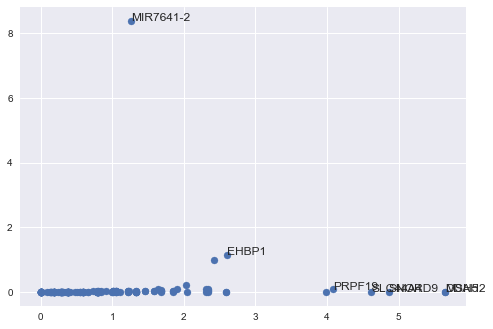

In [14]:
plt.scatter(comb["p1"], comb["p2"])
for label, p1, p2 in zip(comb["gene"], comb["p1"], comb["p2"]):
    if (p1>1 and p2>1) or (p1>4) or (p2>4):
        plt.annotate(label, xy = (p1, p2))
plt.show()

In [8]:
# from itertools import chain
# from collections import defaultdict
# overall_df = defaultdict(list)
# for k,v in chain(pvalue_df_pkl.items(), lfdr_df_rds.items()):
#     # The first element in value is -log10(pvalue) from fisher test, the second is -log10(lfdr)
#     overall_df[k].append(v)
# print (overall_df)

In [86]:
from numpy import inf
test1=np.array([1,3,9,5,6,7,inf])
print (max(test1))
test1[np.isinf(test1)]=10

inf


In [74]:
print (sum(test1))

41.0
